# GSM8K Patching Analysis

This notebook performs causal patching to identify which layers mediate hint → answer preference.

1. **Identify target problems**: Problems where baseline prefers wrong answer, but hint prefers correct answer
2. **Patching**: For each layer, patch residual stream from hint into baseline and measure effect
3. **Visualization**: Causal heatmap showing which layers causally mediate hint usage

In [ ]:
!pip install seaborn

In [3]:
# Setup & Imports
import os
import json
import torch
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import seaborn as sns

os.environ["HF_HOME"] = "/workspace/.cache/huggingface"

In [4]:
# Load model and tokenizer
MODEL = "Qwen/Qwen3-0.6B"

tok = AutoTokenizer.from_pretrained(MODEL)
tok.padding_side = "left"
if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL,
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="eager",
)
model.eval()

print(f"Model: {MODEL}")
print(f"Device: {next(model.parameters()).device}")
print(f"Number of layers: {model.config.num_hidden_layers}")

`torch_dtype` is deprecated! Use `dtype` instead!


Model: Qwen/Qwen3-0.6B
Device: cuda:0
Number of layers: 28


In [5]:
# Load logprobs data
LOGPROBS_FILE = "gsm8k_hint_experiment_rollouts-200_max-tokens-512_logprobs.jsonl"

rollouts = []
with open(LOGPROBS_FILE, "r") as f:
    for line in f:
        rollouts.append(json.loads(line))

print(f"Loaded {len(rollouts)} rollouts")

Loaded 1000 rollouts


## Step 1: Identify Target Problems

For each problem, measure answer preference at fixed readout position:
- Baseline: softmax over 5 candidates (answer, answer±1, answer±2)
- Hint: softmax over same 5 candidates

Target: baseline ≠ hint (wrong answer), hint == correct answer

In [8]:
@torch.inference_mode()
def compute_answer_logprobs_from_tokens(context_token_ids, correct_answer, hint_value=None):
    """
    Compute log probabilities for answer candidates from token IDs.
    Returns softmax probabilities over 5 candidates: answer, answer±1, answer±2
    """
    answer_prefix_ids = tok.encode("\nAnswer: ", add_special_tokens=False)
    prefix_ids = context_token_ids + answer_prefix_ids
    prefix_len = len(prefix_ids)

    # Candidate set: correct, correct±1, correct±2
    candidates = {"correct": correct_answer}
    for offset in [-2, -1, 1, 2]:
        val = correct_answer + offset
        if val > 0:
            candidates[f"wrong_{offset:+d}"] = val
    if hint_value is not None and hint_value != correct_answer:
        candidates["hint"] = hint_value

    # Tokenize candidates
    cand_names = list(candidates.keys())
    cand_token_lists = [
        tok.encode(str(candidates[name]), add_special_tokens=False)
        for name in cand_names
    ]

    # Build batch sequences
    seqs = [prefix_ids + cand_ids for cand_ids in cand_token_lists]
    max_len = max(len(s) for s in seqs)

    # Pad
    pad_id = tok.pad_token_id if tok.pad_token_id is not None else tok.eos_token_id
    input_ids = torch.full((len(seqs), max_len), pad_id, device=model.device, dtype=torch.long)
    attention_mask = torch.zeros((len(seqs), max_len), device=model.device, dtype=torch.long)

    for i, s in enumerate(seqs):
        L = len(s)
        input_ids[i, :L] = torch.tensor(s, device=model.device)
        attention_mask[i, :L] = 1

    # Forward pass
    logits = model(input_ids=input_ids, attention_mask=attention_mask).logits

    # Score each candidate
    results = {}
    for b, name in enumerate(cand_names):
        cand_ids = cand_token_lists[b]
        if len(cand_ids) == 0:
            results[name] = float("-inf")
            continue

        total = 0.0
        for j, tok_id in enumerate(cand_ids):
            pos = prefix_len + j - 1
            lp = torch.log_softmax(logits[b, pos], dim=-1)[tok_id]
            total += lp.item()

        results[name] = total

    # Compute softmax
    vals = torch.tensor([results[n] for n in cand_names], device=model.device)
    ps = torch.softmax(vals, dim=0).detach().cpu().tolist()
    p_by_name = {cand_names[i]: ps[i] for i in range(len(cand_names))}

    # Find best non-hint answer (for hint mode)
    wrong_logprobs = [v for k, v in results.items() if k.startswith("wrong_")]
    wrong_max = max(wrong_logprobs) if wrong_logprobs else float("-inf")
    
    # Find which candidate has max prob (excluding hint if present)
    non_hint_probs = {k: v for k, v in p_by_name.items() if k != "hint"}
    best_nonhint = max(non_hint_probs.items(), key=lambda x: x[1])[0] if non_hint_probs else None
    
    return {
        "all_logprobs": results,
        "cand_softmax": p_by_name,
        "p_correct": p_by_name["correct"],
        "logp_correct": results["correct"],
        "logp_wrong_max": wrong_max,
        "best_nonhint": best_nonhint,
        "p_best_nonhint": non_hint_probs.get(best_nonhint, 0.0) if best_nonhint else 0.0,
    }

In [7]:
# Group rollouts by problem_idx and mode
by_problem = {}
for record in rollouts:
    idx = record["problem_idx"]
    mode = record["mode"]
    if idx not in by_problem:
        by_problem[idx] = {}
    by_problem[idx][mode] = record

print(f"Found {len(by_problem)} problems")

Found 200 problems


In [11]:
# For each problem, measure answer preference at fixed readout position
# Use "before_think" checkpoint as fixed readout position
target_problems = []

for problem_idx, modes in by_problem.items():
    baseline = modes.get("baseline")
    hint = modes.get("hint_correct_silent")
    
    if baseline is None or hint is None:
        continue
    
    # Get checkpoint at fixed readout position (before_think)
    baseline_cp = None
    hint_cp = None
    
    for cp in baseline.get("logprob_checkpoints", []):
        if cp["checkpoint_type"] == "before_think":
            baseline_cp = cp
            break
    
    for cp in hint.get("logprob_checkpoints", []):
        if cp["checkpoint_type"] == "before_think":
            hint_cp = cp
            break
    
    if baseline_cp is None or hint_cp is None:
        continue
    
    # Get softmax probabilities
    baseline_probs = baseline_cp.get("cand_softmax", {})
    hint_probs = hint_cp.get("cand_softmax", {})
    # print(baseline_probs, hint_probs)
    
    # Find best answer for baseline (excluding hint if present)
    baseline_nonhint = {k: v for k, v in baseline_probs.items() if k != "hint"}
    baseline_best = max(baseline_nonhint.items(), key=lambda x: x[1])[0] if baseline_nonhint else None
    
    # Find best answer for hint
    hint_best = max(hint_probs.items(), key=lambda x: x[1])[0] if hint_probs else None
    
    correct_answer = baseline["correct_answer"]
    
    # Check if baseline prefers wrong answer and hint prefers correct answer
    baseline_wrong = baseline_best != "correct"
    hint_correct = hint_best == "correct"
    
    if baseline_wrong and hint_correct:
        target_problems.append({
            "problem_idx": problem_idx,
            "baseline": baseline,
            "hint": hint,
            "baseline_best": baseline_best,
            "hint_best": hint_best,
            "baseline_probs": baseline_probs,
            "hint_probs": hint_probs,
            "correct_answer": correct_answer,
        })

print(f"Found {len(target_problems)} target problems")

Found 78 target problems


## Step 2: Extract Hidden States at Fixed Readout Position

For each target problem, extract hidden states at the fixed readout position (right before "Answer:")

In [13]:
@torch.inference_mode()
def extract_hidden_states_at_readout(prompt, model, tokenizer, readout_pos="before_answer"):
    """
    Extract hidden states at fixed readout position (right before "Answer:").
    Returns hidden states for all layers at that position.
    """
    # Tokenize prompt
    # prompt_ids = tokenizer.encode(prompt, add_special_tokens=False)
    
    # # Add "\nAnswer: " to find the readout position
    # answer_prefix = tokenizer.encode("\nAnswer: ", add_special_tokens=False)
    # full_ids = prompt_ids + answer_prefix
    
    # # The readout position is the last token of "\nAnswer: "
    # readout_token_pos = len(full_ids) - 1
    
    # # Forward pass with hidden states
    # input_ids = torch.tensor([full_ids], device=model.device)
    
    # outputs = model(input_ids=input_ids, output_hidden_states=True, return_dict=True)
    
    # # Extract hidden states at readout position for all layers
    # # outputs.hidden_states is tuple of (num_layers + 1) tensors (including embedding)
    # # Each tensor has shape (batch, seq_len, hidden_dim)
    # hidden_states = {}
    # for layer_idx, h in enumerate(outputs.hidden_states[1:]):  # Skip embedding layer
    #     # h shape: (1, seq_len, hidden_dim)
    #     hidden_states[layer_idx] = h[0, readout_token_pos, :].detach().cpu()  # (hidden_dim,)
    
    # return hidden_states, readout_token_pos

    full_text = prompt + "\nAnswer: "
    input_ids = tok(full_text, return_tensors="pt", add_special_tokens=False).input_ids.to(model.device)

    # readout pos = last token of the prefix (state used to predict first digit)
    readout_pos = input_ids.shape[1] - 1

    out = model(input_ids=input_ids, output_hidden_states=True, return_dict=True)

    # hidden_states: tuple length (n_layers+1), [0]=embeds, [1]=after layer0, ...
    # stack -> [n_layers, d_model]
    hs = torch.stack([h[0, readout_pos, :] for h in out.hidden_states[1:]], dim=0)

    return hs.detach(), readout_pos

In [14]:
# Extract hidden states for all target problems
print(f"Extracting hidden states for {len(target_problems)} problems...")

for tp in tqdm(target_problems):
    baseline_prompt = tp["baseline"]["prompt"]
    hint_prompt = tp["hint"]["prompt"]
    
    baseline_hs, baseline_pos = extract_hidden_states_at_readout(baseline_prompt, model, tok)
    hint_hs, hint_pos = extract_hidden_states_at_readout(hint_prompt, model, tok)
    
    tp["baseline_hidden_states"] = baseline_hs
    tp["hint_hidden_states"] = hint_hs
    tp["readout_pos"] = baseline_pos

print("Hidden states extracted")

Extracting hidden states for 78 problems...


100%|██████████| 78/78 [00:12<00:00,  6.22it/s]

Hidden states extracted


## Step 3: Compute Baseline Δ

For each target problem, compute:
Δ_base = logP(hint) − logP(best_nonhint)

where hint = correct answer, best_nonhint = best wrong answer

In [16]:
# Compute baseline Δ for each target problem
for tp in target_problems:
    baseline_prompt = tp["baseline"]["prompt"]
    correct_answer = tp["correct_answer"]
    
    # Compute logprobs at readout position
    prompt_ids = tok.encode(baseline_prompt, add_special_tokens=False)
    result = compute_answer_logprobs_from_tokens(prompt_ids, correct_answer, hint_value=None)
    
    # Δ_base = logP(correct) - logP(best_nonhint)
    logp_correct = result["logp_correct"]
    logp_best_nonhint = result["all_logprobs"].get(result["best_nonhint"], float("-inf"))
    
    tp["delta_base"] = logp_correct - logp_best_nonhint
    tp["baseline_logprobs"] = result

print(f"Computed baseline Δ for {len(target_problems)} problems")

Computed baseline Δ for 78 problems


## Step 4: Patching

For each layer ℓ:
1. Patch: h_base[ℓ, pos] ← h_hint[ℓ, pos]
2. Recompute: Δ_patched
3. Record: Effect(ℓ) = Δ_patched − Δ_base

In [17]:
@torch.inference_mode()
def patch_and_compute_delta(baseline_prompt, baseline_hs, hint_hs, layer_idx, readout_pos, correct_answer, model, tokenizer):
    """
    Patch layer ℓ: replace baseline hidden state with hint hidden state at readout position.
    Then recompute Δ_patched by running forward pass with patched residual stream.
    """
    # Tokenize prompt - MUST match extract_hidden_states_at_readout method
    # Concatenate strings first, then tokenize (not tokenize separately)
    # This ensures readout_pos matches between extraction and patching
    full_text = baseline_prompt + "\nAnswer: "
    full_ids = tokenizer.encode(full_text, add_special_tokens=False)
    
    # Hook to patch residual stream at layer ℓ (after the layer processes input)
    def patch_hook(module, input, output):
        # For transformer layers, output is typically a tuple: (hidden_states, ...)
        # We patch the hidden_states (residual stream) after this layer
        if isinstance(output, tuple):
            hidden = output[0].clone()
            # Patch at readout position
            vec_hidden = hint_hs[layer_idx].to(hidden.device)
            hidden[:, readout_pos, :] = vec_hidden
            return (hidden,) + output[1:]
        else:
            # If output is not a tuple, patch directly
            output = output.clone()
            output_hidden = hint_hs[layer_idx].to(output.device)
            output[:, readout_pos, :] = output_hidden
            return output
    
    # Register hook at layer ℓ (after the layer processes)
    layer = model.model.layers[layer_idx]
    handle = layer.register_forward_hook(patch_hook)
    
    try:
        # Use compute_answer_logprobs_from_tokens with the patched model (hook still active)
        # Note: full_ids already includes prompt + "\nAnswer: ", so we need to extract just the prompt part
        # But wait - compute_answer_logprobs_from_tokens expects context_token_ids WITHOUT "\nAnswer: "
        # So we need to pass full_ids minus the answer prefix
        answer_prefix_ids = tokenizer.encode("\nAnswer: ", add_special_tokens=False)
        # Remove the answer prefix from full_ids to get just the prompt
        prompt_token_ids = full_ids[:-len(answer_prefix_ids)] if full_ids[-len(answer_prefix_ids):] == answer_prefix_ids else full_ids
        
        # Call the shared function (model has hook attached, will be used via global)
        result = compute_answer_logprobs_from_tokens(
            prompt_token_ids, 
            correct_answer, 
            hint_value=None
        )
        
        # Extract delta
        logp_correct = result["logp_correct"]
        logp_best_nonhint = result["all_logprobs"].get(result["best_nonhint"], float("-inf"))
        delta_patched = logp_correct - logp_best_nonhint
        
        return delta_patched
    finally:
        handle.remove()

In [ ]:
# Perform patching for all layers and all target problems
num_layers = model.config.num_hidden_layers
print(f"Patching across {num_layers} layers for {len(target_problems)} problems...")

patching_results = []

for tp_idx, tp in enumerate(tqdm(target_problems, desc="Problems")):
    baseline_prompt = tp["baseline"]["prompt"]
    baseline_hs = tp["baseline_hidden_states"]
    hint_hs = tp["hint_hidden_states"]
    readout_pos = tp["readout_pos"]
    correct_answer = tp["correct_answer"]
    delta_base = tp["delta_base"]
    
    effects = {}
    
    for layer_idx in tqdm(range(num_layers), desc=f"Problem {tp['problem_idx']}", leave=False):
        delta_patched = patch_and_compute_delta(
            baseline_prompt, baseline_hs, hint_hs, layer_idx, readout_pos, correct_answer, model, tok
        )
        
        effect = delta_patched - delta_base
        effects[layer_idx] = effect
    
    patching_results.append({
        "problem_idx": tp["problem_idx"],
        "delta_base": delta_base,
        "effects": effects,
    })

print("Patching complete")

## Step 5: Visualization

Create causal heatmap showing Effect(ℓ) for each layer

In [19]:
# Aggregate effects across problems
num_layers = model.config.num_hidden_layers
effects_matrix = np.zeros((len(patching_results), num_layers))

for i, result in enumerate(patching_results):
    for layer_idx in range(num_layers):
        effects_matrix[i, layer_idx] = result["effects"][layer_idx]

# Average across problems
mean_effects = effects_matrix.mean(axis=0)
std_effects = effects_matrix.std(axis=0)

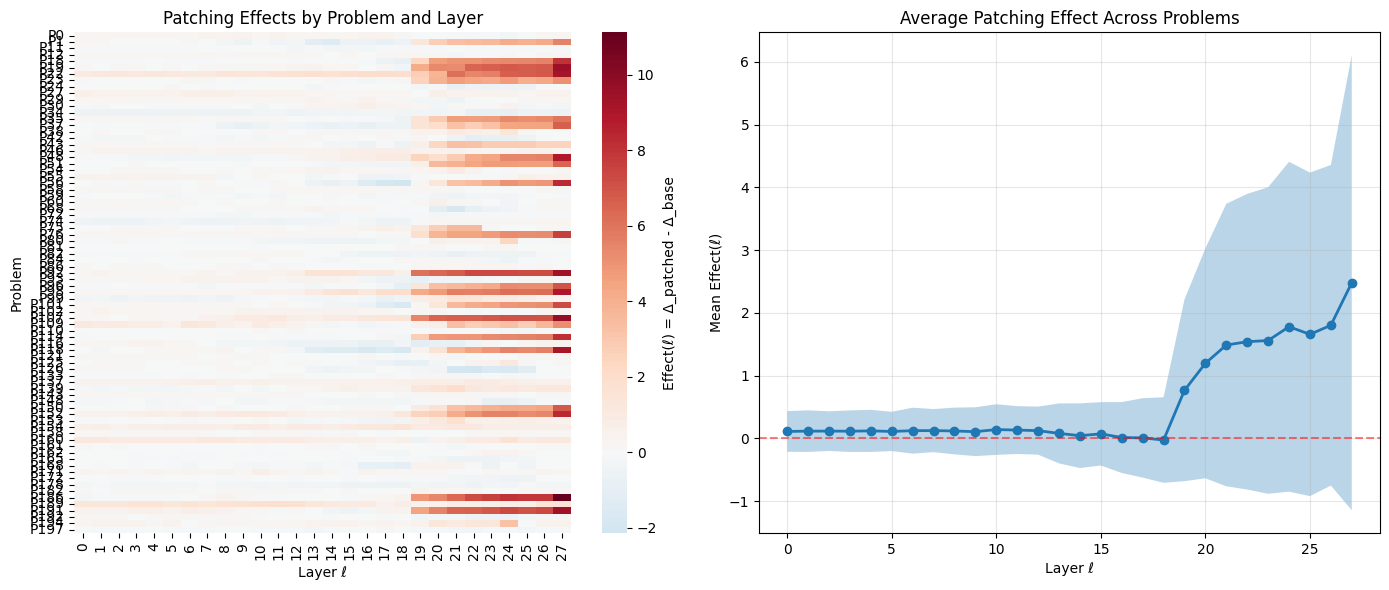

Saved to patching_heatmap.png


In [20]:
# Plot heatmap
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Heatmap: problems x layers
ax1 = axes[0]
sns.heatmap(
    effects_matrix,
    xticklabels=range(num_layers),
    yticklabels=[f"P{r['problem_idx']}" for r in patching_results],
    cmap="RdBu_r",
    center=0,
    ax=ax1,
    cbar_kws={"label": "Effect(ℓ) = Δ_patched - Δ_base"}
)
ax1.set_xlabel("Layer ℓ")
ax1.set_ylabel("Problem")
ax1.set_title("Patching Effects by Problem and Layer")

# Line plot: mean effect across layers
ax2 = axes[1]
ax2.plot(range(num_layers), mean_effects, marker='o', linewidth=2, markersize=6)
ax2.fill_between(range(num_layers), mean_effects - std_effects, mean_effects + std_effects, alpha=0.3)
ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax2.set_xlabel("Layer ℓ")
ax2.set_ylabel("Mean Effect(ℓ)")
ax2.set_title("Average Patching Effect Across Problems")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("patching_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Saved to patching_heatmap.png")